Anthony Niznik

In [1]:
#Pkg.rm("LowRankModels")

In [2]:
#Pkg.clone("http://github.com/madeleineudell/LowRankModels.jl")

In [3]:
using DataFrames, PyPlot, ScikitLearn, LowRankModels

Question 1

Part C

In [4]:
# module ProximalGradient

using LowRankModels

import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w::Array{Float64,1}, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w::Array{Float64,1}, y) = X'*grad(loss, X*w, y)
evaluate(loss::Loss, X::Array{Float64,2}, w::Array{Float64,2}, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w::Array{Float64,2}, y) = X'*grad(loss, X*w, y)

export evaluate, grad, proxgrad, is_differentiable

is_differentiable(l::QuadLoss) = true
is_differentiable(l::L1Loss) = false
is_differentiable(l::HuberLoss) = true
is_differentiable(l::QuantileLoss) = false
is_differentiable(l::PoissonLoss) = true
is_differentiable(l::WeightedHingeLoss) = false
is_differentiable(l::LogisticLoss) = true
is_differentiable(l::OrdinalHingeLoss) = false
is_differentiable(l::OrdisticLoss) = true
is_differentiable(l::MultinomialOrdinalLoss) = true
is_differentiable(l::BvSLoss) = is_differentiable(l.bin_loss)
is_differentiable(l::MultinomialLoss) = true
is_differentiable(l::OvALoss) = is_differentiable(l.bin_loss)
is_differentiable(l::PeriodicLoss) = true

function proxgrad(loss::Loss, args...; kwargs...)
  return proxgrad_linesearch(loss, args...; kwargs...)
  # if is_differentiable(loss)
  #   return proxgrad_linesearch(loss, args...; kwargs...)
  # else
  #   return proxgrad_dec(loss, args...; kwargs...)
  # end
end

function proxgrad_linesearch(loss::Loss, reg::Regularizer, X::Array{Float64,2}, y;
                  maxiters = 100,
                  stepsize = 1,
                  w = (embedding_dim(loss)==1 ? zeros(size(X,2)) : zeros(size(X,2), embedding_dim(loss))),
                  ch = ConvergenceHistory("proxgrad"))
    update_ch!(ch, 0, evaluate(loss, X, w, y) + evaluate(reg, w))
    t = time()
    for i=1:maxiters
        # gradient
        g = grad(loss, X, w, y)
        # prox gradient step
        neww = prox(reg, w - stepsize*g, stepsize)
        # record objective value
        curobj = evaluate(loss, X, neww, y) + evaluate(reg, neww)
        if curobj > ch.objective[end]
          stepsize *= .5
        else
          copy!(w, neww)
          t, told = time(), t
          update_ch!(ch, t - told, curobj)
        end
    end
    return w
end

function proxgrad_dec(loss::Loss, reg::Regularizer, X::Array{Float64,2}, y;
                  maxiters = 100,
                  stepsize = 1,
                  w = (embedding_dim(loss)==1 ? zeros(size(X,2)) : zeros(size(X,2), embedding_dim(loss))),
                  ch = ConvergenceHistory("proxgrad"),
                  verbose = true)
    wbest = copy(w)
    update_ch!(ch, 0, evaluate(loss, X, w, y) + evaluate(reg, w))
    t = time()
    if verbose
      println("using decreasing stepsize for nondifferentiable loss")
    end
    for i=1:maxiters
        # gradient
        g = grad(loss, X, w, y)
        # prox gradient step
        w = prox(reg, w - stepsize/i*g, stepsize/i)
        # record objective value
        obj = evaluate(loss, X, w, y) + evaluate(reg, w)
        if obj < ch.objective[end]
          if verbose
            println("found a better obj $obj")
          end
          copy!(wbest, w)
          update_ch!(ch, time() - t, obj)
        end
    end
    return wbest
end

function proxgrad_const(loss::Loss, reg::Regularizer, X::Array{Float64,2}, y;
                  maxiters = 100,
                  stepsize = 1,
                  w = (embedding_dim(loss)==1 ? zeros(size(X,2)) : zeros(size(X,2), embedding_dim(loss))),
                  ch = ConvergenceHistory("proxgrad"))
    wbest = copy(w)
    update_ch!(ch, 0, evaluate(loss, X, w, y) + evaluate(reg, w))
    t = time()
    for i=1:maxiters
        # gradient
        g = grad(loss, X, w, y)
        # prox gradient step
        w = prox(reg, w - stepsize*g, stepsize)
        # record objective value
        obj = evaluate(loss, X, w, y) + evaluate(reg, w)
        if obj < ch.objective[end]
          copy!(wbest, w)
          update_ch!(ch, time() - t, obj)
        end    end
    return wbest
end


# end


proxgrad_const (generic function with 1 method)

In [5]:
cancer = readtable("breast-cancer.csv", separator = '\,', header = false)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
1,-1,5,1,1,1,2,1,3,1,1
2,-1,5,4,4,5,7,10,3,2,1
3,-1,3,1,1,1,2,2,3,1,1
4,-1,6,8,8,1,3,4,3,7,1
5,-1,4,1,1,3,2,1,3,1,1
6,1,8,10,10,8,7,10,9,7,1
7,-1,1,1,1,1,2,10,3,1,1
8,-1,2,1,2,1,2,1,3,1,1
9,-1,2,1,1,1,2,1,1,1,5
10,-1,4,2,1,1,2,1,2,1,1


In [6]:

function splitrandom_indices(n::Integer, proportion::Real)
    
    include = zeros(342,1)
    exclude = zeros(341,1)
    
    indices = Array(Int64, n) 
for i in 1:n
        indices[i]= i
end
    shuffle!(indices)
    #splitindex = iround(n * proportion)
    
    splitindex = 342
    
    for i = 1:splitindex
        include[i] = indices[i]
    end
    
      for i = splitindex: 683
        j=1
        exclude[j] = indices[i]
        j=j+1
    end
    
    return indices[1:splitindex], indices[(splitindex + 1):n]
end

function splitrandom(df::AbstractDataFrame, proportion::Real)
    included, excluded = splitrandom_indices(size(df,1), proportion)
    return df[included, :], df[excluded, :]
end

splitrandom (generic function with 1 method)

In [7]:
train_data, test_data = splitrandom(cancer, 0.5)
train_data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
1,-1,2,2,2,1,1,1,7,1,1
2,1,3,7,7,4,4,9,4,8,1
3,-1,1,1,1,1,2,1,3,1,1
4,-1,5,1,1,1,2,1,3,1,2
5,-1,5,1,1,1,2,1,2,1,1
6,1,8,10,10,10,8,10,10,7,3
7,1,8,8,9,4,5,10,7,8,1
8,1,5,3,3,1,3,3,3,3,3
9,-1,1,1,1,1,2,1,1,1,1
10,-1,5,1,1,1,2,1,1,1,1


In [8]:
X_train = train_data[:, 2:end]
y_train = train_data[1]
X_test = test_data[:, 2:end]
y_test = test_data[1]

341-element DataArrays.DataArray{Int64,1}:
  1
  1
 -1
  1
  1
 -1
  1
  1
 -1
 -1
  1
  1
 -1
  ⋮
 -1
 -1
 -1
  1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

In [9]:
X_train_A = convert(Array{Float64,2},X_train)
y_train_A = convert(Array{Int64},y_train)

X_test_A = convert(Array{Float64,2},X_test)
y_test_A = convert(Array{Int64},y_test)

341-element Array{Int64,1}:
  1
  1
 -1
  1
  1
 -1
  1
  1
 -1
 -1
  1
  1
 -1
  ⋮
 -1
 -1
 -1
  1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

In [10]:
#Lipshitz Constant
L = 1/(2*norm(X_train_A)^2)


9.685477070360733e-6

In [11]:
#Logistic
wʰ = proxgrad(HingeLoss(), QuadReg(), X_train_A, y_train_A; maxiters = 10000, stepsize = L)
wˡ = proxgrad(LogisticLoss(), QuadReg(), X_train_A, y_train_A; maxiters = 10000, stepsize = L)



9-element Array{Float64,1}:
 -0.295487 
  0.696902 
  0.372876 
  0.0688191
 -0.64203  
  0.5513   
 -0.554788 
  0.245235 
 -0.203072 

Part D

In [12]:
size(pred_hinge,1)

LoadError: LoadError: UndefVarError: pred_hinge not defined
while loading In[12], in expression starting on line 1

In [26]:
pred_hinge = sign(X_test_A*wʰ)
pred_logistic = sign(X_test_A*wˡ)

rate_hinge = 0
rate_logistic = 0

for i = 1:size(pred_logistic,1)
    if pred_hinge[i] != y_test_A[i]
        rate_hinge = rate_hinge + 1
    end
    
    if pred_logistic[i] != y_test_A[i]
        rate_logistic = rate_logistic + 1
    end
end

Misclassification_Rate_Hinge = rate_hinge/size(pred_hinge,1)
Misclassification_Rate_Logistic = rate_logistic/size(pred_logistic,1)

Misclassification_Rate_Hinge
Misclassification_Rate_Logistic

0.1348973607038123

Misclassification_Rate_Hinge = 0.1466275659824047

Misclassification_Rate_Logistic = 0.1495601173020528

Hinge does a better job of classification.

Part E

Logistic loss does not have a normalizing constant because it is smooth and differentiable at all points. Also, when you can integrate its pdf and see that it integrates to one which means it is a real probability distribution function. This means that it naturally creates probabilities for classification. 

Part F

In [14]:
z_new=0
z_old=0
for i = 1:size(y_test_A,1)
    
    z_old = exp(-1*(evaluate(HingeLoss(), model_hinge[i], 1))) + exp(-1*(evaluate(HingeLoss(), model_hinge[i], -1)))
    z_new = z_new + z_old
    
end

LoadError: LoadError: UndefVarError: model_hinge not defined
while loading In[14], in expression starting on line 3

In [15]:
#X_test_A*wʰ
logl = 0
likelihood_logistic = 0
logh = 0
likelihood_hinge = 0
z = z_new / size(y_test_A,1)
model_log = X_test_A*wˡ
model_hinge = X_test_A*wʰ

for i = 1:size(y_test_A,1)
    
    logl = -(evaluate(LogisticLoss(), model_log[i], y_test_A[i]))
    likelihood_logistic = likelihood_logistic + logl
    
end

for i = 1:size(y_test_A,1)
    
    logh = log((1/z)*exp(-1*(evaluate(HingeLoss(), model_hinge[i], y_test_A[i]))))
    likelihood_hinge = likelihood_hinge + logh
    
end

likelihood_logistic
likelihood_hinge

Inf

likelihood_logistic = -175.79344455713954
likelihood_hinge = -169.57714215306166

The log likelihood of hinge is larger.

Problem 3

In [16]:
birth = readtable("birthSample.txt", separator = '\t')

,MaritalStatus,PrenatalCare,Male,Weight
1,0,1,0,3326
2,1,0,0,1340
3,0,0,0,3033
4,1,1,1,3884
5,0,0,0,3108
6,1,1,1,3912
7,1,1,1,2546
8,1,1,1,4545
9,0,1,0,3402
10,1,1,1,3884


# a) Fit an ordinary least squares regression to the data. Interpret the coefficients that you find

In [17]:
n = size(birth,1)
X = [birth[:MaritalStatus].data birth[:PrenatalCare].data birth[:Male].data ones(n)]
y = birth[:Weight].data
w=X\y

4-element Array{Float64,1}:
  101.362 
   73.0585
  124.357 
 3138.93  

1st coefficient: This means that if the parents of the baby are married, then the baby will weigh on average 101.362 grams more. 2nd coefficient: This means that if the mother received prenatal care, then the baby will weigh on average 73.0585 grams more. 3rd coefficient: This means that if the baby is male, then the baby will weigh on average 124.357 grams more than a female.
4th coefficient: This means that on average a baby weighs 3138.93 grams when the baby is female, did not have prenatal care, and had unmmarried parents. 

# b) Fit a quantile regression on the data with $q=0.05$ and $q=0.95$. Compare these coefficients to those you found in part a).

In [18]:
QuantileLoss(scale=1.0::Float64; domain=RealDomain(), quantile=.05::Float64) = QuantileLoss(scale, domain, quantile)
w_q5 = proxgrad(QuantileLoss(), ZeroReg(), X, y;)

4-element Array{Float64,1}:
  237.375
  161.725
   61.025
 2120.55 

In [19]:
QuantileLoss(scale=1.0::Float64; domain=RealDomain(), quantile=.95::Float64) = QuantileLoss(scale, domain, quantile)
w_q95 = proxgrad(QuantileLoss(), ZeroReg(), X, y;)

4-element Array{Float64,1}:
   82.3672
   67.3422
  198.744 
 3932.29  

These models predict how much a baby weighs that lies in the kth percentile of the baby weight distribution. The least squares predicts the average baby weight while these models predict the kth percentile of baby weight. We see that for the 5th percentile babies that the intercept is lower than the least squares prediction and that the parents being married and prenatal care has a bigger affect on baby weight too. Whether the baby is male of female has less of an effect for the 5th percentile than for least squares.

For the 95th percentile, the intercept starts much higher than the least squares intercept. Also, marital status and prenatal care have less of an effect on baby weight for the 95th percentile than for least squares prediction. However, the gender of the baby has more of an effect on average for the 95th percentile than for the least squares prediction.

# c) Fit quantile regressions for $q=0.05, 0.10, \cdots, 0.95$.

In [20]:
Marital = Float64[]
Prenatal = Float64[]
M = Float64[]
Intercept = Float64[]
w_new = 0

#for Q in quantiles
for i = 1:19
    
    w_new = proxgrad(QuantileLoss(quantile=0.05*i), ZeroReg(), X, y)
    
      push!(Marital, w_new[1])
      push!(Prenatal, w_new[2])
      push!(M, w_new[3])
      push!(Intercept, w_new[4])
    
end



# d) Create an intercept plot that plots quantiles against the intercept coefficient from that quantile regression. Create coefficient plots for MaritalStatus, Male, and PrenatalCare coefficients.


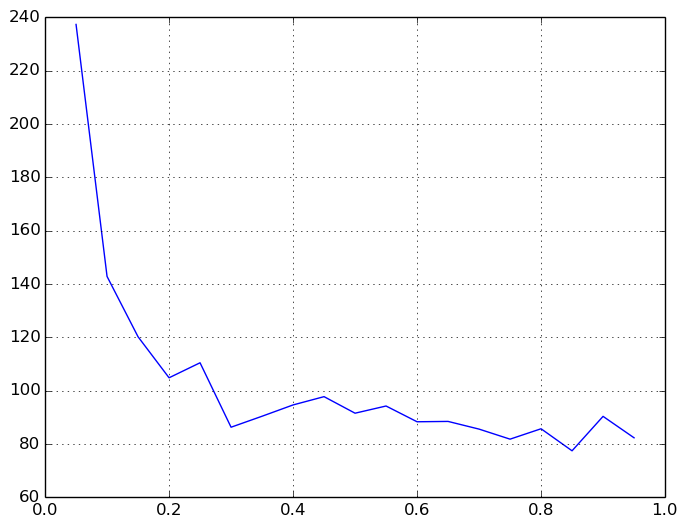

In [21]:
Quantile_Range = []

for i = 1:19
    j = 0.05*i
    push!(Quantile_Range,j)
end
Quantile_Range
plot(Quantile_Range, Marital)
grid("on")

As the quantile increases, marital status has less of an effect on baby weight on average.

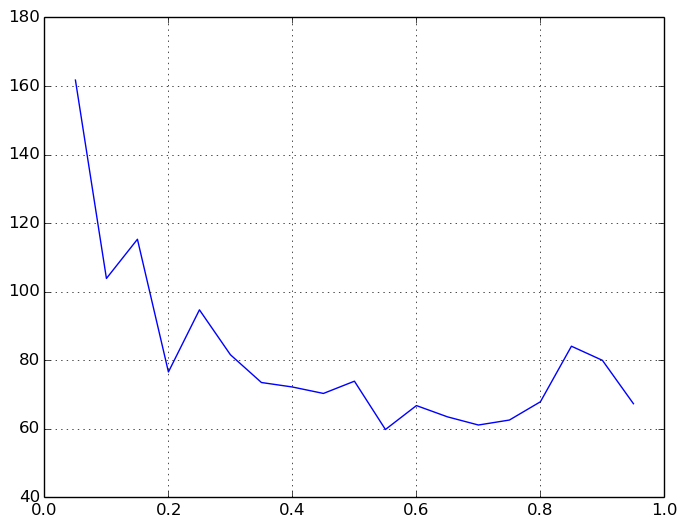

In [22]:
plot(Quantile_Range, Prenatal)
grid("on")

As the quantile increases, prenatal care has less of an effect on baby weight on average.

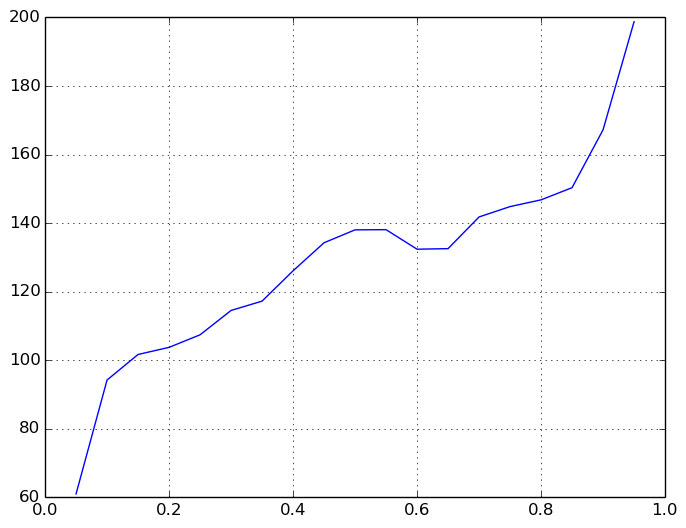

In [23]:
plot(Quantile_Range, M)
grid("on")

As the quantile increases, gender has more of an effect on baby weight on average (weight increases if the baby is male on average).

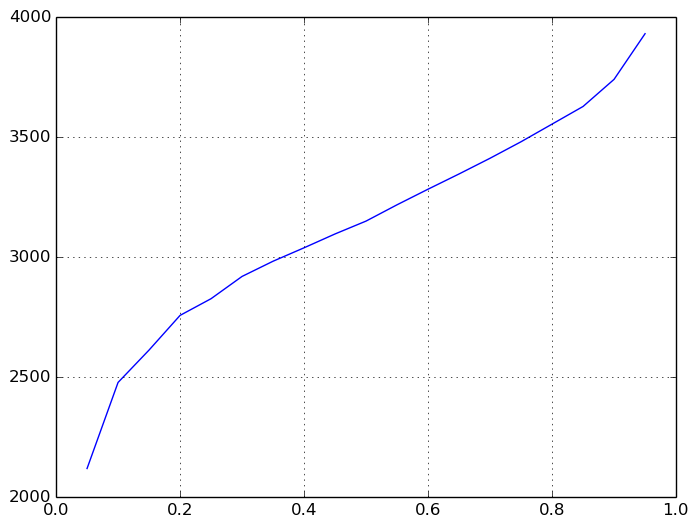

In [24]:
plot(Quantile_Range, Intercept)
grid("on")

# e) How should you interpret the intercepts of the quantile regressions?

The intercept is the baseline weight of babies on average when the baby is female, did not have prenatal care, and had unmmarried parents. As the quantile increases, the average baby weight increases.

# f) What does the coefficient plot tell you about the effect of prenatal care for infants with low birth weight compared to those with average birth weights?

Prenatal care has more of an effect on babies weight on average if the baby is lower in birth weight as compared to babies with average birth rate.